In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [4]:
root_dir = '/kaggle/working/'
train_dataset = FashionMNIST(os.path.join(root_dir, './data'), train= True, download = True, transform = transforms.ToTensor())
test_dataset = FashionMNIST(os.path.join(root_dir, './data'), train= False, download = True, transform = transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.0MB/s]


Extracting /kaggle/working/./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting /kaggle/working/./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.94MB/s]


Extracting /kaggle/working/./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.8MB/s]

Extracting /kaggle/working/./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/./data/FashionMNIST/raw



In [5]:
batch_size = 512
train_ratio = 0.9

train_size = int(len(train_dataset) * 0.9)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset,[train_size, val_size])

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


In [8]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std =1.0)
                nn.init.constant_(module.bias, 0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

def compute_accuracy(preds, labels):
    acc = (torch.argmax(preds, dim = 1) == labels).sum()
    return acc

In [9]:
input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [10]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0
    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)

        optimizer.zero_grad()
        preds = model.forward(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_acc += compute_accuracy(preds, y_train)
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss.detach().cpu().numpy())
    train_acc /= count
    train_acc_lst.append(train_acc.detach().cpu().numpy())



    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            preds = model.forward(X_val)
            loss = criterion(preds, y_val)
            val_loss += loss
            val_acc += compute_accuracy(preds, y_val)
            count += len(y_val)

    val_loss /= len(test_loader)
    val_loss_lst.append(val_loss.detach().cpu().numpy())
    val_acc /= count
    val_acc_lst.append(val_acc.detach().cpu().numpy())

    print(f"EPOCH {epoch + 1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 4.1082, Train_Acc: 0.1834, Validation Loss: 1.3233, Val_Acc: 0.2307
EPOCH 2/100, Train_Loss: 2.0284, Train_Acc: 0.2856, Validation Loss: 1.1436, Val_Acc: 0.3317
EPOCH 3/100, Train_Loss: 1.7839, Train_Acc: 0.3702, Validation Loss: 1.0232, Val_Acc: 0.3933
EPOCH 4/100, Train_Loss: 1.6172, Train_Acc: 0.4251, Validation Loss: 0.9416, Val_Acc: 0.4423
EPOCH 5/100, Train_Loss: 1.5005, Train_Acc: 0.4642, Validation Loss: 0.8810, Val_Acc: 0.4765
EPOCH 6/100, Train_Loss: 1.4126, Train_Acc: 0.4928, Validation Loss: 0.8357, Val_Acc: 0.5013
EPOCH 7/100, Train_Loss: 1.3454, Train_Acc: 0.5169, Validation Loss: 0.7984, Val_Acc: 0.5225
EPOCH 8/100, Train_Loss: 1.2895, Train_Acc: 0.5355, Validation Loss: 0.7687, Val_Acc: 0.5427
EPOCH 9/100, Train_Loss: 1.2430, Train_Acc: 0.5530, Validation Loss: 0.7436, Val_Acc: 0.5587
EPOCH 10/100, Train_Loss: 1.2037, Train_Acc: 0.5673, Validation Loss: 0.7210, Val_Acc: 0.5723
EPOCH 11/100, Train_Loss: 1.1693, Train_Acc: 0.5802, Validation Loss:

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

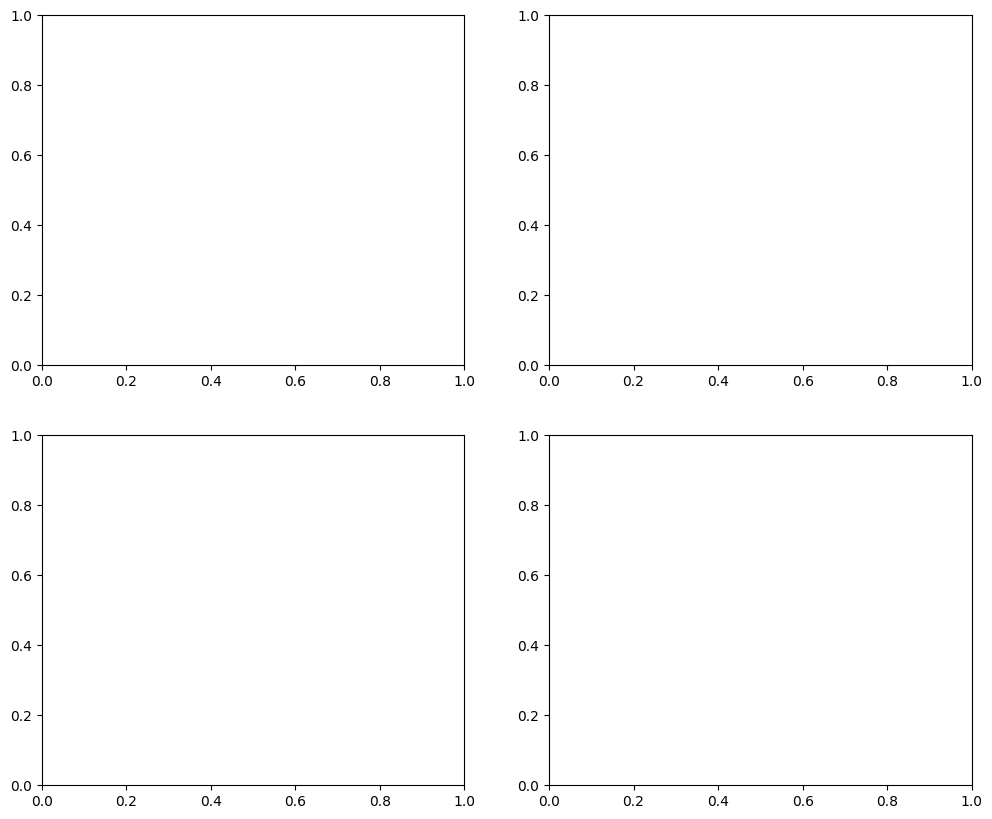

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
val_target = []
val_predict = []

model.eval()
with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device)
        y_val = y_val.to(device)
        outputs = model(X_val)

        val_predict.append(outputs.cpu())
        val_target.append(y_val.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = (torch.argmax(val_predict, 1) == val_target).sum().item() / len(val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')